## 투빅스 18기 Week3 Neural Netwrk Basic 과제 - 18기 이다인

## Import Library

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from dataset.mnist import load_mnist
import math

## Load Dataset
- MNIST 

In [2]:
(X_train, Y_train), (X_test, Y_test) = \
    load_mnist(normalize=True, one_hot_label=False)

In [3]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {Y_train.shape}')
print(f'Y_train shape: {Y_test.shape}')

X_train shape: (60000, 784)
X_test shape: (10000, 784)
Y_train shape: (60000,)
Y_train shape: (10000,)


## Activation Function 
- sigmoid & relu : hidden layer activation function 
- softmax : output layer activation function 

In [4]:
class sigmoid:
    # sigmoid 함수를 작성하세요 
    def forward(x):
        z = np.exp(-x)
        sig = 1 / (1 + z)
        return sig
    
    # sigmoid 함수의 미분을 작성하세요
    def backward(x):
        result = x * (1 - x)
        return result

In [5]:
class relu:
    # relu 함수를 작성하세요
    def forward(x):
        return np.maximum(0, x)
    
    # relu 함수의 미분을 작성하세요
    def backward(x):
        return np.where(x > 0, 1, 0)

In [6]:
class softmax:
    def forward(z):
        y = []
        for zi in z:
            c = np.max(zi)
            exp_zi = np.exp(zi-c)
            sum_exp_zi = np.sum(exp_zi)
            yi = exp_zi / sum_exp_zi
            y.append(yi)

        return np.array(y)
    
    def backward(p, y) :
        dp = p.copy()
        for dpi, yi in zip(dp, y):
            for k in range(dp.shape[1]):
                if k == yi :
                    dpi[k] -= 1
        return dp

## Loss Function

In [7]:
def cross_entropy(p, y):
    loss = []
    for pi, yi in zip(p, y):
        for k in range(p.shape[1]):
            if k == yi:
                loss.append((-1) * (np.log(pi[k] + 1e-8))) 
    return loss

## Layer

In [8]:
class Layer:
    def __init__(self, input_size, output_size, std=1e-4) :
        self.input_size = input_size
        self.output_size = output_size
        self.bias = np.random.randn(output_size)
        self.weight = np.random.randn(input_size, output_size)*std

## Neural Network
- 각 메소드와 변수들의 역할을 주석으로 달아주세요! 

In [9]:
class CustomNet:
    # CustomNet을 선언할 때 생성되는 값들입니다.
    def __init__(self, lr=0.0001, epoch=500, batch_size=200):
        self.lr = lr #가중치 업데이트에 이용 될 학습률
        self.epoch = epoch  #모델이 학습을 반복할 횟수
        self.batch_size = batch_size #모델이 한 번 학습할 때 사용될 데이터 사이즈
        self.loss_function = cross_entropy #모댈의 손실함수 지정(cross entropy) :모델의 성능 평가에 이용
        self.layers = [] #인공신경망에 쌓을 레이어 층
        self.activations = [softmax] #활성화 함수
        self.nodes = [] #레이어 층 안에 노드
    
    # Layer를 추가할 때 호출합니다
    def addLayer(self, Layer): 
        self.layers.append(Layer) #입력값을 통해 레이어를 추가
        if not self.nodes: #노드가 비어있을 때 
            self.nodes.append(np.zeros(Layer.input_size)) #input size만큼 노드 추가
        self.nodes.append(np.zeros(Layer.output_size)) #노드가 비어있지 않다면 output_size를 추가
        
    # Activation Function을 추가할 때 호출합니다
    def addActivation(self, Activation):
        tmp = self.activations.pop() #가장 마지막에 있는 활성화 함수를 tmp에 지정
        self.activations.append(Activation) #입력한 활성화 함수를 추가
        self.activations.append(tmp) #지정된 활성화 함수를 다시 추가
        
    # 순전파 함수
    def _forward(self, X):
        self.nodes[0] = X.copy() #복사한 x의 노드를 초기화
        output = X.copy() #output에 x의 값을 복사해 넣음
        for i in range(len(self.layers)): 
            Layer = self.layers[i] 
            Activation = self.activations[i] 
            output = np.dot(self.nodes[i], Layer.weight) #노드의 값과 가중치의 값의 행렬곱
            output = output+ Layer.bias # 행렬곱한 값에 bias 값을 더함
            output = Activation.forward(output) #bias를 더한 값에 활성화 함수 적용
            self.nodes[i+1] = output 
        return output   
    
    # 역전파 함수
    def _backward(self, X, output, y) :
        for i in reversed(range(len(self.layers))): 
            a = self.nodes[i+1] 
            Layer = self.layers[i] #현재의 레이어 값을 따로 지정
            Activation = self.activations[i] #활성화 함수 지정
            # error 를 층별로 계산
            if i+1 == len(self.layers): 
                error = Activation.backward(output, y)
            else:
                error *= Activation.backward(a)
            Layer.weight -= np.dot(error.T, self.nodes[i]).T*self.lr/X.shape[0] #error값과 학습률을 통해 가중치 업데이트
            Layer.bias -= error.sum(axis=0)*self.lr/X.shape[0] #error값과 학습률을 통해 bias 값 업데이트
            error = np.dot(error, Layer.weight.T) 
            
    # Accrucy를 반환합니다
    def _accuracy(self, output, y):
        pre_p = np.argmax(output, axis=1) 
        return np.sum(pre_p==y)/y.shape[0] 
    
    # 데이터셋에 모델을 fit할때 호출합니다
    def fit(self, X, y, val_X, val_y):
        history = {'val_acc': [],'val_loss': []}
        N = X.shape[0]
        for i in range(self.epoch): #epoch의 값 만큼 수행
            for j in range(N//self.batch_size): #한 번 학습할 때 batch size만큼 수행
                batch_mask = np.random.choice(N, self.batch_size) 
                X_batch = X[batch_mask] 
                y_batch = y[batch_mask] 
                output = self._forward(X_batch) #배치 데이터의 순전파 수행
                self._backward(X_batch, output, y_batch) #배치 데이터의 역전파 수행
            
            #accuracy와 loss를 기록해둡시다
            output = self._forward(val_X) #val데이터 순전파 수행
            history["val_acc"].append(self._accuracy(output, val_y)) #정확도 저장
            history["val_loss"].append(sum(self.loss_function(output, val_y))) #loss값 저장
            
            #중간중간 기록을 찍어볼 때 사용. 적절히 조절해 쓰세요
            if i % 10 == 0:
                print(i, "test accuracy :", history["val_acc"][-1])
                print(i, "test loss     :", history["val_loss"][-1])
        return history

## Customizing
- Network parameter, Layer architecture, Activation function .. 등등 다양한 하이퍼파라미터를 커스터마이징하여 높은 성능에 도달해 봅시다! 

### 1

In [10]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.005, epoch=200, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(784,100))
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

In [11]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [12]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.101
0 test loss     : 23183.58985493967
10 test accuracy : 0.1185
10 test loss     : 22830.211740717343
20 test accuracy : 0.139
20 test loss     : 22460.340682752572
30 test accuracy : 0.2366
30 test loss     : 21595.16396061517
40 test accuracy : 0.275
40 test loss     : 20362.96495206935
50 test accuracy : 0.3122
50 test loss     : 19271.2904557583
60 test accuracy : 0.3817
60 test loss     : 18058.356633121864
70 test accuracy : 0.4347
70 test loss     : 16355.470135049618
80 test accuracy : 0.487
80 test loss     : 14619.783894173543
90 test accuracy : 0.5549
90 test loss     : 13168.50784948348
100 test accuracy : 0.6228
100 test loss     : 11881.388974663836
110 test accuracy : 0.6814
110 test loss     : 10687.064377226498
120 test accuracy : 0.7246
120 test loss     : 9586.823710726076
130 test accuracy : 0.76
130 test loss     : 8631.689426592417
140 test accuracy : 0.7891
140 test loss     : 7829.684278109321
150 test accuracy : 0.8093
150 test loss     : 

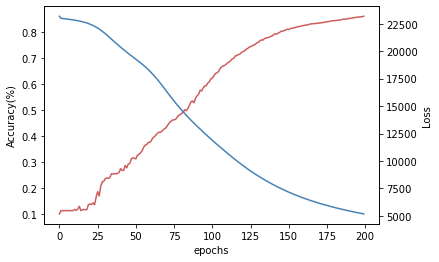

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(range(200), history['val_acc'], color='indianred')
plt.xlabel('epochs')
plt.ylabel('Accuracy(%)')
ax2 = ax.twinx()
ax2.plot(range(200), history['val_loss'], color='steelblue')
plt.ylabel('Loss')

plt.show()

### 2

In [16]:
nn = CustomNet(lr=0.005, epoch=100, batch_size=300)
nn.addLayer(Layer(784,100))
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [17]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1135
0 test loss     : 23009.650816155026
10 test accuracy : 0.1159
10 test loss     : 22942.34793675043
20 test accuracy : 0.2071
20 test loss     : 22835.004418467608
30 test accuracy : 0.2224
30 test loss     : 22532.235484309072
40 test accuracy : 0.2124
40 test loss     : 21545.81573741241
50 test accuracy : 0.3742
50 test loss     : 19618.444270119646
60 test accuracy : 0.446
60 test loss     : 16738.377142089506
70 test accuracy : 0.5519
70 test loss     : 14024.368744331565
80 test accuracy : 0.6562
80 test loss     : 11809.598274260501
90 test accuracy : 0.7201
90 test loss     : 9962.777058578748


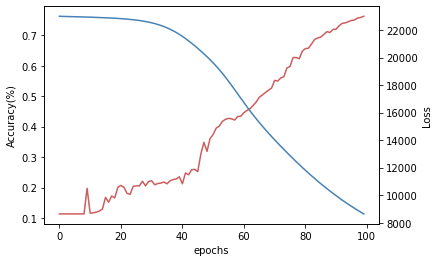

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(range(100), history['val_acc'], color='indianred')
plt.xlabel('epochs')
plt.ylabel('Accuracy(%)')
ax2 = ax.twinx()
ax2.plot(range(100), history['val_loss'], color='steelblue')
plt.ylabel('Loss')

plt.show()

### 3

In [19]:
nn = CustomNet(lr=0.005, epoch=100, batch_size=300)
nn.addLayer(Layer(784,100))
nn.addActivation(relu)
nn.addLayer(Layer(100,10))

for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [20]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1135
0 test loss     : 22959.702296706913
10 test accuracy : 0.2808
10 test loss     : 21007.38802061765
20 test accuracy : 0.7318
20 test loss     : 9153.603835424123
30 test accuracy : 0.8303
30 test loss     : 5768.508635161431
40 test accuracy : 0.8762
40 test loss     : 4418.713215595423
50 test accuracy : 0.8914
50 test loss     : 3797.3798084212153
60 test accuracy : 0.9
60 test loss     : 3473.9331644423432
70 test accuracy : 0.9046
70 test loss     : 3268.244838091262
80 test accuracy : 0.9102
80 test loss     : 3116.2650043972944
90 test accuracy : 0.9143
90 test loss     : 2997.6129927657607


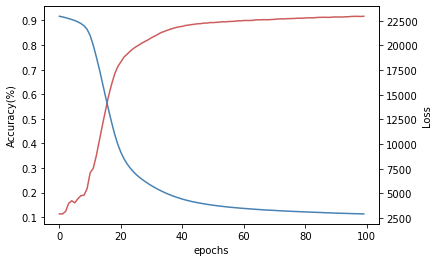

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(range(100), history['val_acc'], color='indianred')
plt.xlabel('epochs')
plt.ylabel('Accuracy(%)')
ax2 = ax.twinx()
ax2.plot(range(100), history['val_loss'], color='steelblue')
plt.ylabel('Loss')

plt.show()

### 4

In [22]:
nn = CustomNet(lr=0.005, epoch=200, batch_size=400)
nn.addLayer(Layer(784,100))
nn.addActivation(relu)
nn.addLayer(Layer(100,10))

for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [23]:
history = nn.fit(X_train, Y_train, X_test, Y_test)

0 test accuracy : 0.1136
0 test loss     : 22984.226280742234
10 test accuracy : 0.1703
10 test loss     : 22385.70649628043
20 test accuracy : 0.5576
20 test loss     : 14585.95867337484
30 test accuracy : 0.787
30 test loss     : 7592.746445764468
40 test accuracy : 0.8476
40 test loss     : 5473.966090544566
50 test accuracy : 0.8779
50 test loss     : 4459.983558189002
60 test accuracy : 0.8907
60 test loss     : 3943.380162470489
70 test accuracy : 0.8968
70 test loss     : 3646.283725325423
80 test accuracy : 0.9033
80 test loss     : 3450.6447133698193
90 test accuracy : 0.9058
90 test loss     : 3297.4231590298164
100 test accuracy : 0.9085
100 test loss     : 3186.6030482823994
110 test accuracy : 0.912
110 test loss     : 3093.2202127127075
120 test accuracy : 0.9146
120 test loss     : 3011.3513306417835
130 test accuracy : 0.9161
130 test loss     : 2940.1241065880567
140 test accuracy : 0.9184
140 test loss     : 2876.5801764759417
150 test accuracy : 0.9207
150 test loss 

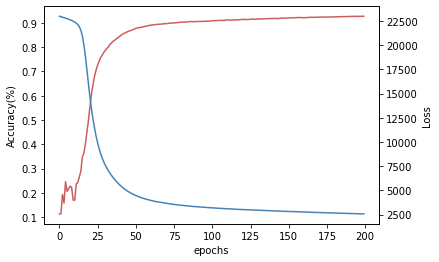

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(range(200), history['val_acc'], color='indianred')
plt.xlabel('epochs')
plt.ylabel('Accuracy(%)')
ax2 = ax.twinx()
ax2.plot(range(200), history['val_loss'], color='steelblue')
plt.ylabel('Loss')

plt.show()

* Sigmoid함수를 사용했을 때보다 Relu함수를 활성화 함수로 사용했을 때 정확도가 훨씬 올라간 것을 알 수 있으며, epoch와 batch_size를 각각 200과 400으로 설정했을 때 학습시간은 훨씬 늘지만 더 높은 정확도를 보이는 것을 확인할 수 있다.

## Accuracy, Loss Visualization
- 자유롭게 Accuracy나 Loss를 시각화하여 확인하고 결과를 확인해 보세요! 

In [ ]:
# 위에서 시각화 같이 진행했습니다!!